In [579]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from constants import cameraMat
from cv2 import circle,triangulatePoints,cvtColor,line,COLOR_GRAY2RGB,computeCorrespondEpilines,putText,FONT_HERSHEY_SIMPLEX,imwrite,Rodrigues
from myLib import isCollinear,isEqual,swapElements,getSignal,getOrder,reshapeCoord,findNearestC,myProjectionPoints,orderCenterCoord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import os
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat
import cv2
from itertools import permutations,combinations


In [580]:
Rodrigues(np.identity(3))[0]

array([[0.],
       [0.],
       [0.]])

#### Calibration

In [594]:
#dfCSV = np.genfromtxt('dataset_2.6m/working3/cam_all.csv', delimiter=',')
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/17Jun/camCalib.csv', delimiter=',')
verbose = False
nCameras = 3
recTime = 90
step = 0.01

In [595]:
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(nCameras,dtype=np.bool8),[],[]
dfOrig,tol = [],0.25
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    timeIntervals.append([])

while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    idx = int(line[8])
    # get points
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    i+=1
    # add proccesing per occlusion here
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(time-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if isCollinear(*undCoord) and not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])
                if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end][6]/1e6,2))+'s')
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:6]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:6]).reshape(-1,2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = time,imgNumber,0
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(6),time))))
    counter[idx]+=1
    # check if ABC is in order smaller to largest
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2:    
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx],0:2],dfOrig[idx][intervals[idx][-1]:counter[idx],4:6] = np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],4:6]),np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],0:2])
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:  certainty[idx] = True

# get last interval
for idx in range(nCameras):
    if not len(dfOrig[idx]): continue
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])    
        if verbose: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end,6]/1e6,2))+'s')

for i in range(nCameras): 
    print('  >> camera '+str(i)+': '+str(len(dfOrig[i]))+' captured valid images images, missed '+str(int(missed[i]))+' images')
            
## verbose
#os.system('rm pics/cam1/*')
#os.system('rm pics/cam2/*')
'''for idx in range(2):
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''


  >> camera 0: 1996 captured valid images images, missed 319 images
  >> camera 1: 2472 captured valid images images, missed 654 images
  >> camera 2: 1377 captured valid images images, missed 314 images


"for idx in range(2):\n    for j in range(0,dfOrig[idx].shape[0]):\n        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0\n        for k in range(0,3):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

In [596]:
from cv2 import line
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
        i+=1
    return img1,img2


interpolated 3080 images between cams 0 and 1
[INFO] Computing fundamental and essential matrix between cameras 0-1
Scale between real world and triang. point cloud is:  404.18
L_AC >> mean = 15.7492cm, std. dev = 0.1825cm, rms = 0.189cm
L_AB >> mean = 5.3896cm, std. dev = 0.091cm, rms = 0.1431cm
L_BC >> mean = 10.3863cm, std. dev = 0.1321cm, rms = 0.2284cm
Images distant more than 1% from the real value = 918/3080


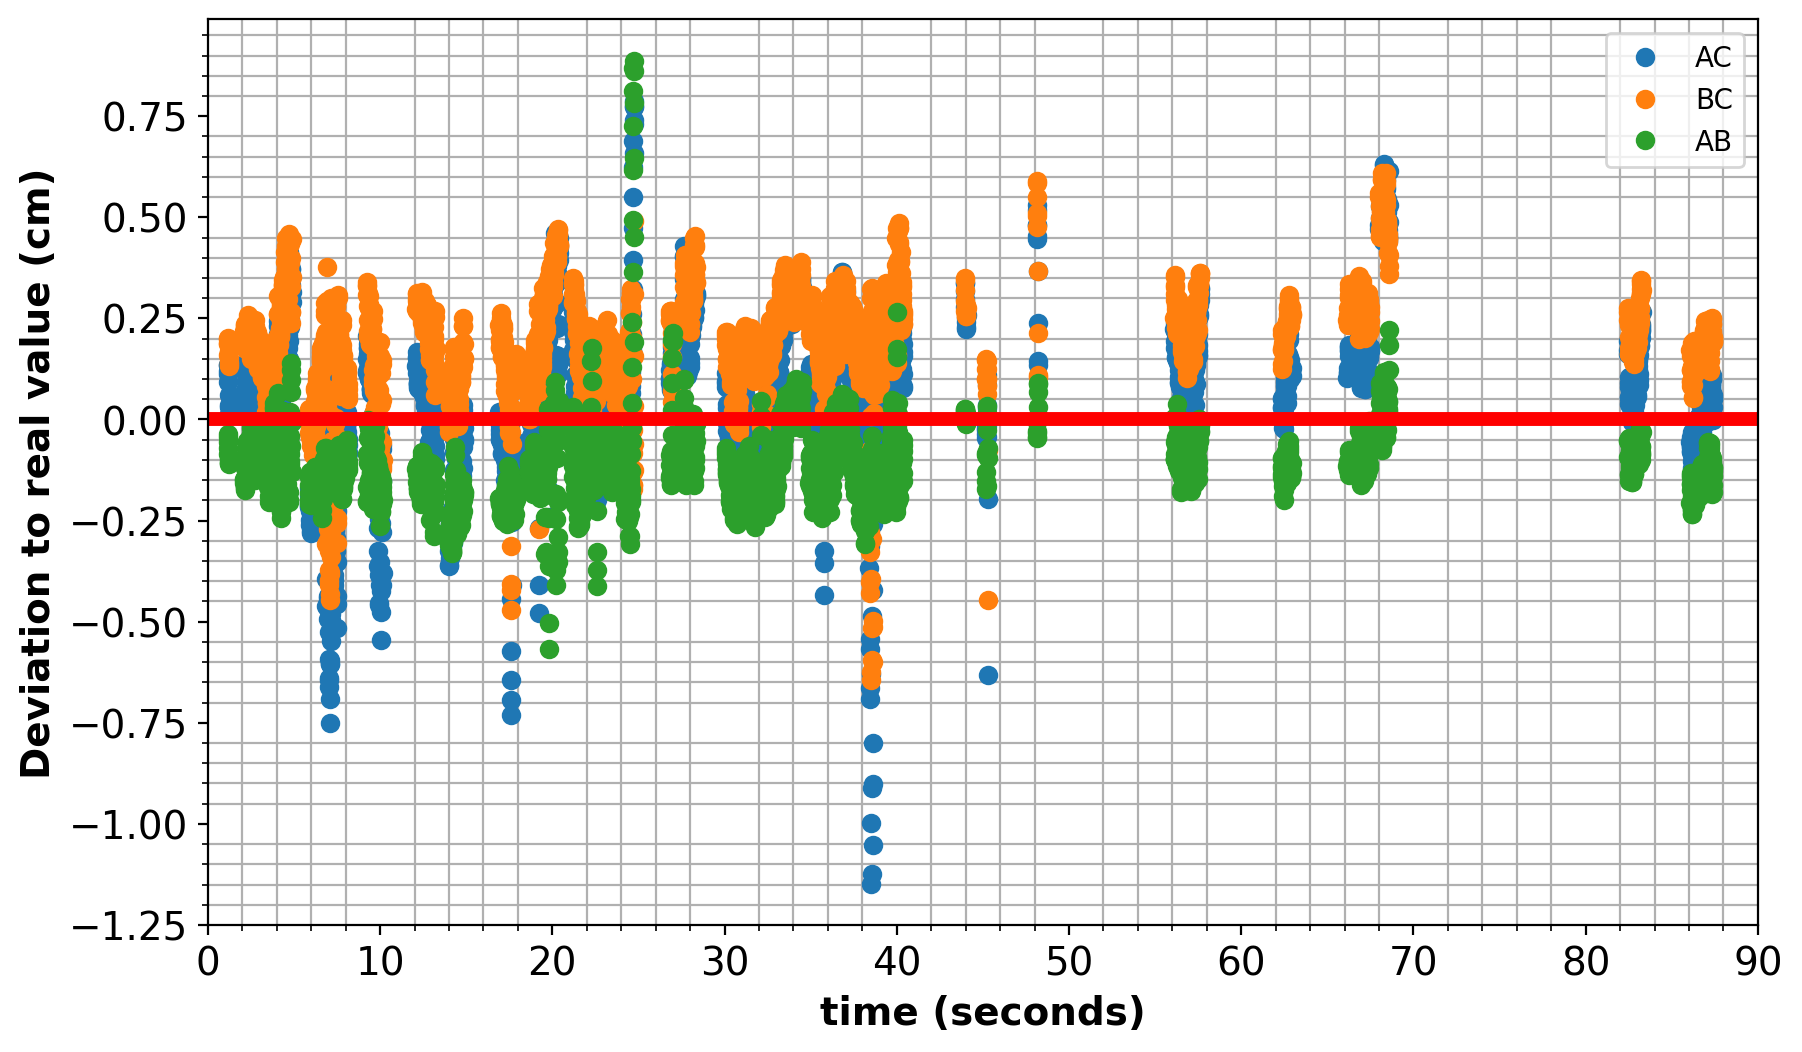

[INFO] Refining fundamental matrix estimation
Scale between real world and triang. point cloud is:  405.26
L_AC >> mean = 15.7537cm, std. dev = 0.0712cm, rms = 0.0892cm
L_AB >> mean = 5.38cm, std. dev = 0.0536cm, rms = 0.1314cm
L_BC >> mean = 10.3981cm, std. dev = 0.0632cm, rms = 0.2079cm


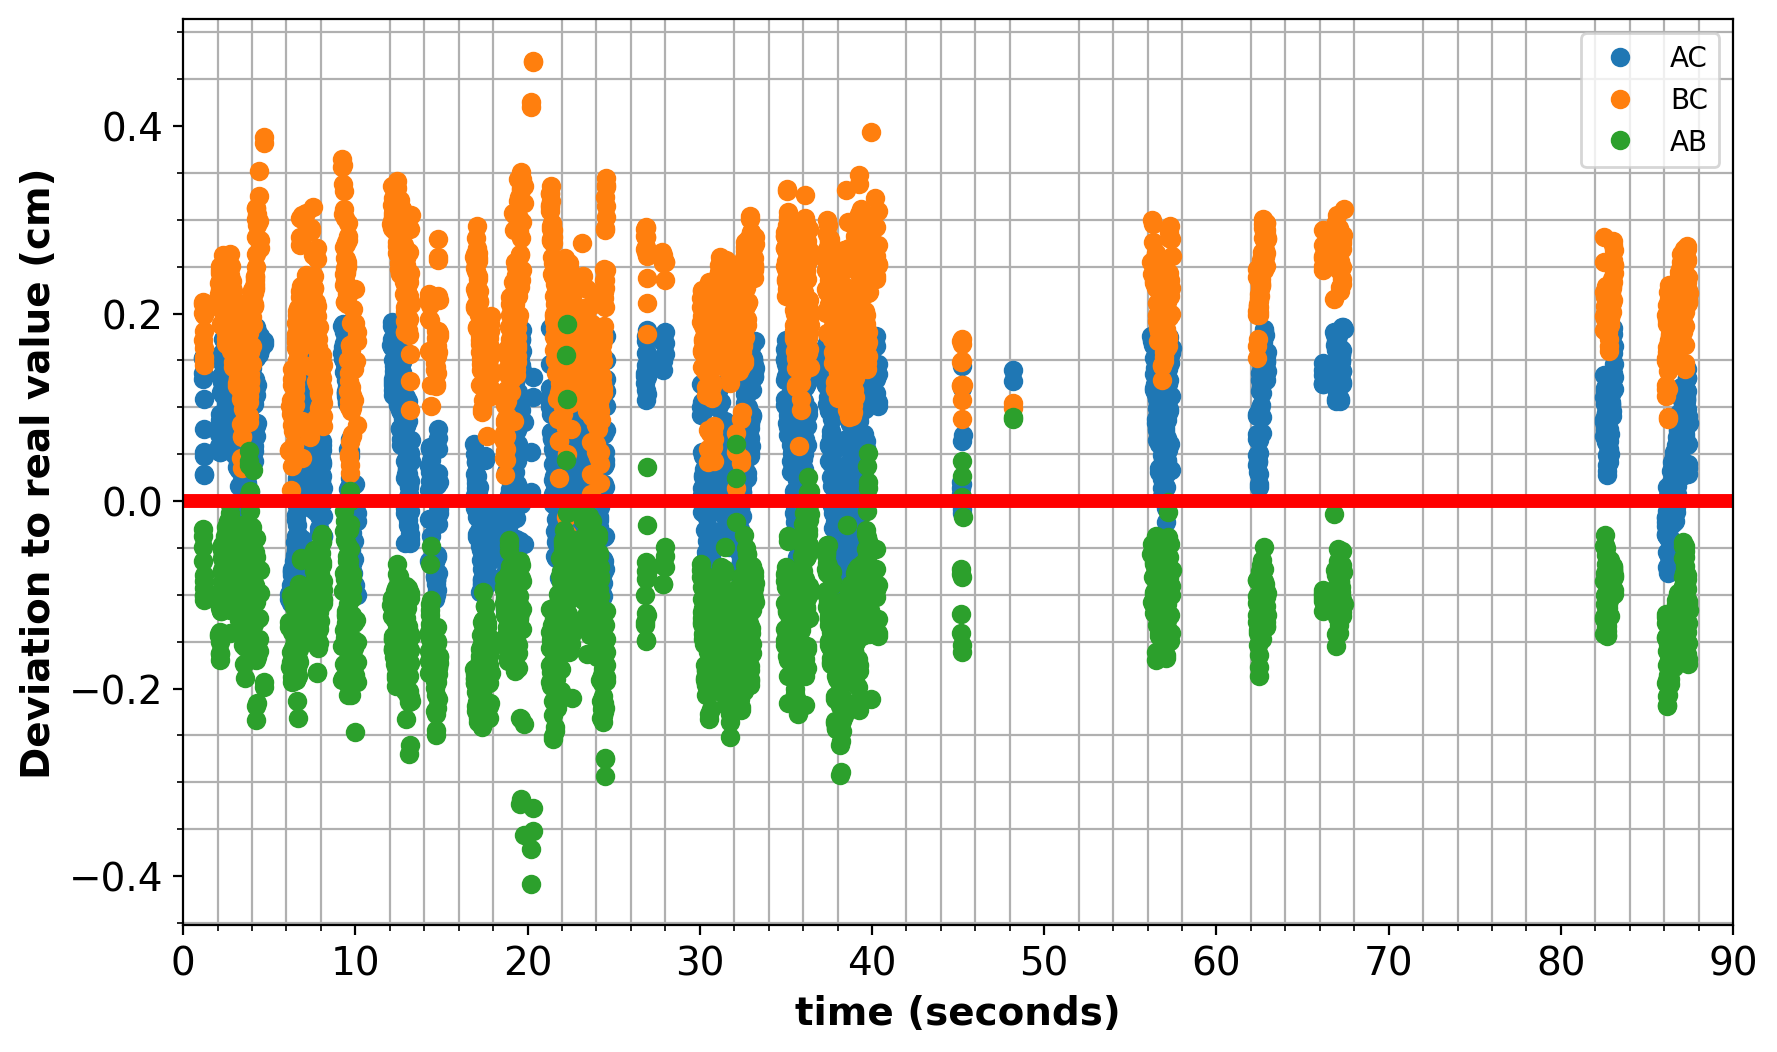

--
interpolated 387 images between cams 0 and 2
[INFO] Computing fundamental and essential matrix between cameras 0-2
Scale between real world and triang. point cloud is:  582.63
L_AC >> mean = 15.8243cm, std. dev = 1.1862cm, rms = 1.1927cm
L_AB >> mean = 5.4637cm, std. dev = 0.3559cm, rms = 0.3578cm
L_BC >> mean = 10.3761cm, std. dev = 0.8534cm, rms = 0.8713cm
Images distant more than 1% from the real value = 357/387


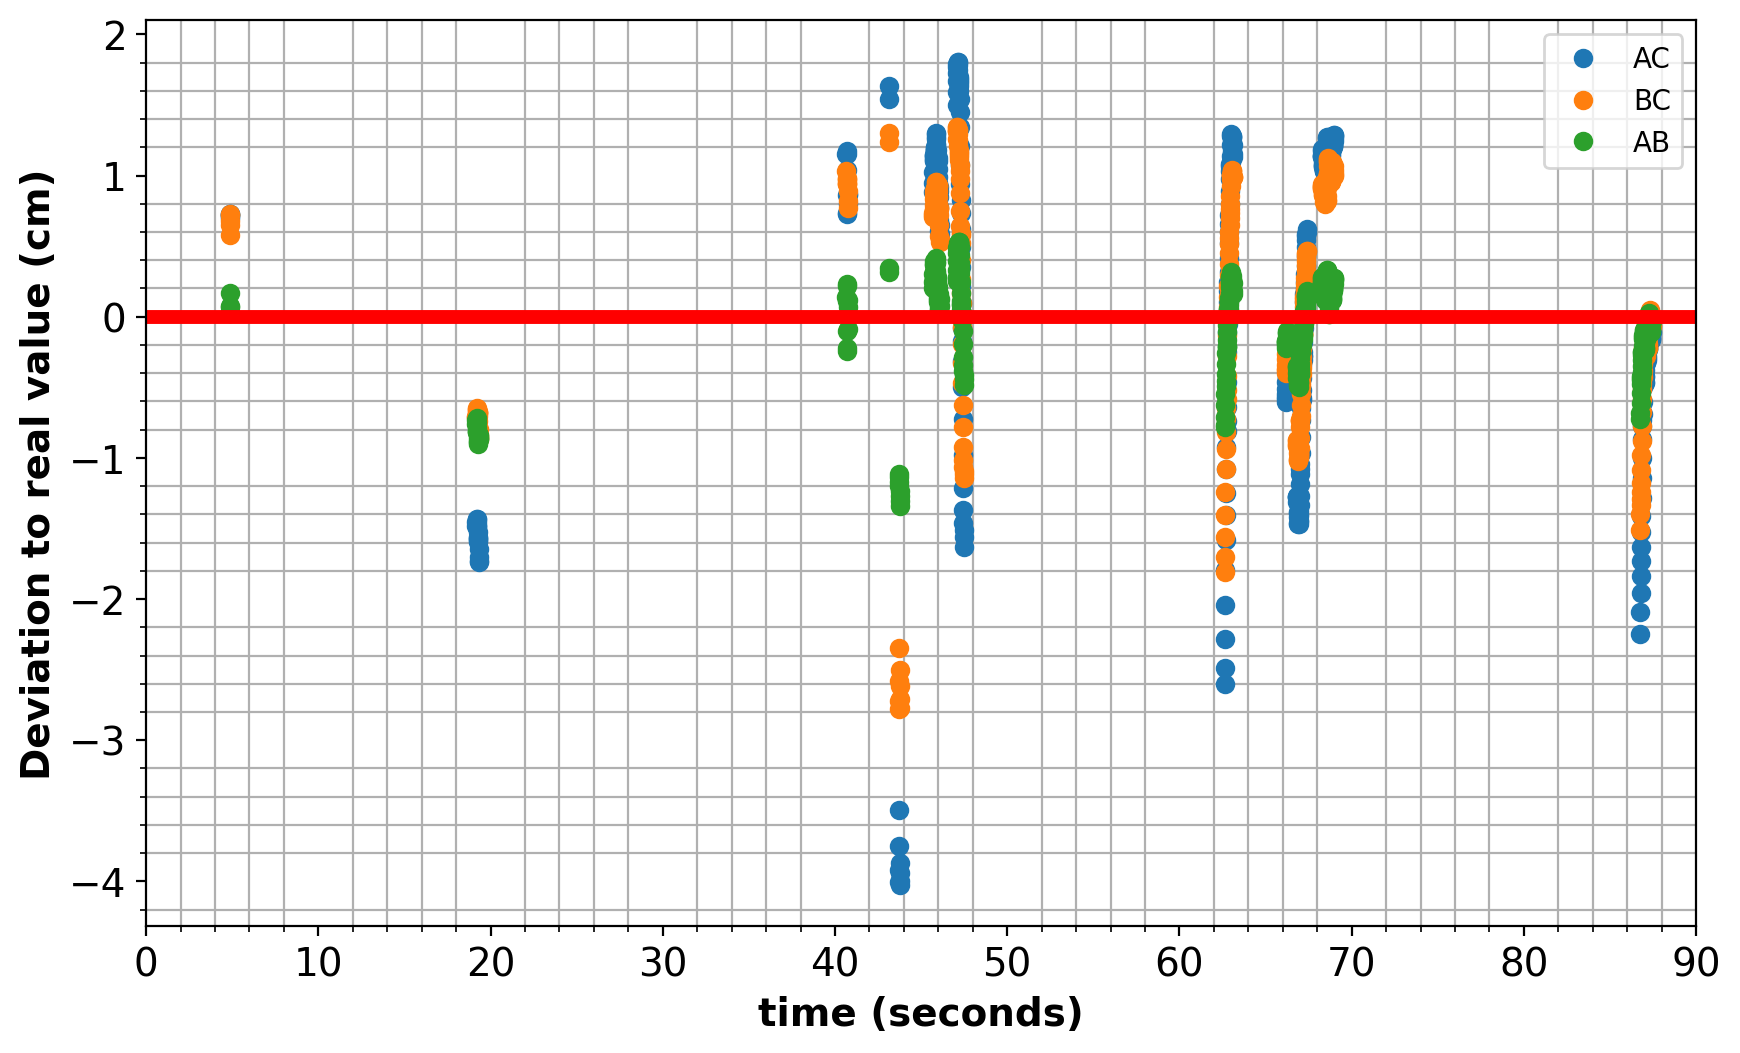

[INFO] Refining fundamental matrix estimation
Scale between real world and triang. point cloud is:  609.85
L_AC >> mean = 15.7136cm, std. dev = 0.2384cm, rms = 0.2388cm
L_AB >> mean = 5.466cm, std. dev = 0.0902cm, rms = 0.0964cm
L_BC >> mean = 10.2622cm, std. dev = 0.1543cm, rms = 0.1664cm


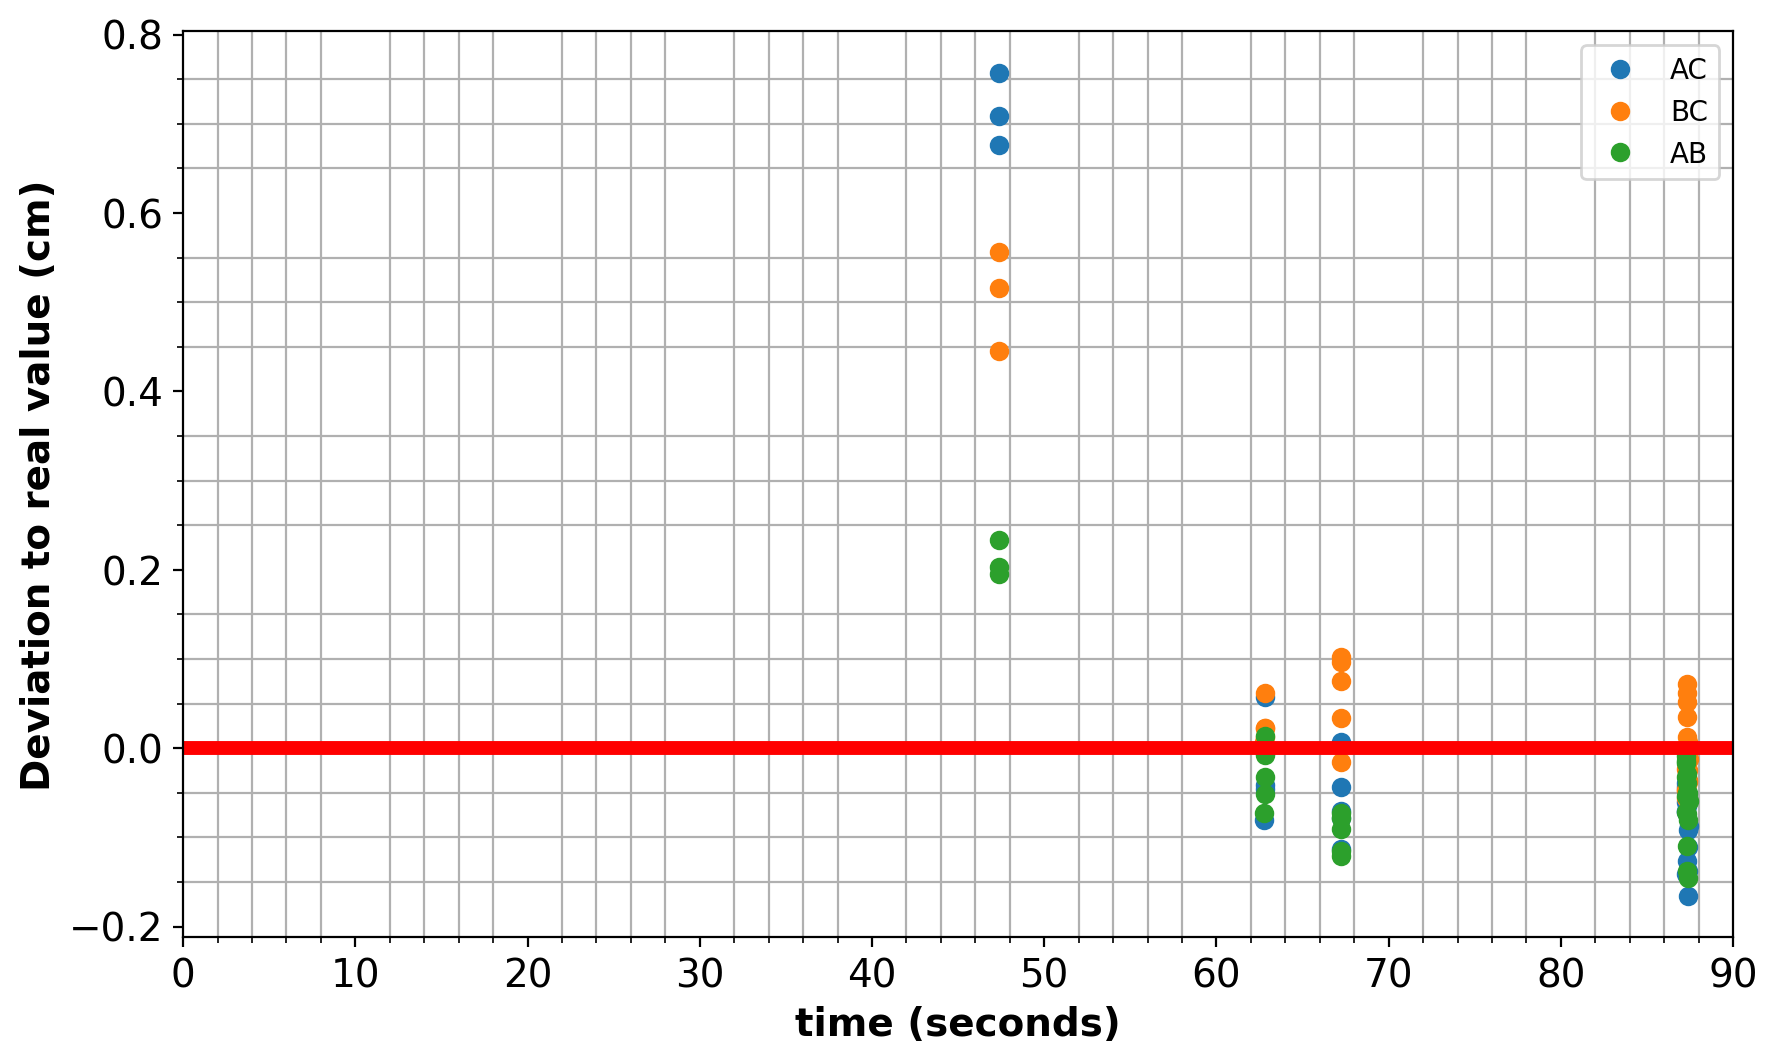

--
interpolated 2091 images between cams 1 and 2
[INFO] Computing fundamental and essential matrix between cameras 1-2
Scale between real world and triang. point cloud is:  460.89
L_AC >> mean = 15.7688cm, std. dev = 0.3852cm, rms = 0.3913cm
L_AB >> mean = 5.3733cm, std. dev = 0.1307cm, rms = 0.1821cm
L_BC >> mean = 10.4204cm, std. dev = 0.2738cm, rms = 0.3514cm
Images distant more than 1% from the real value = 1321/2091


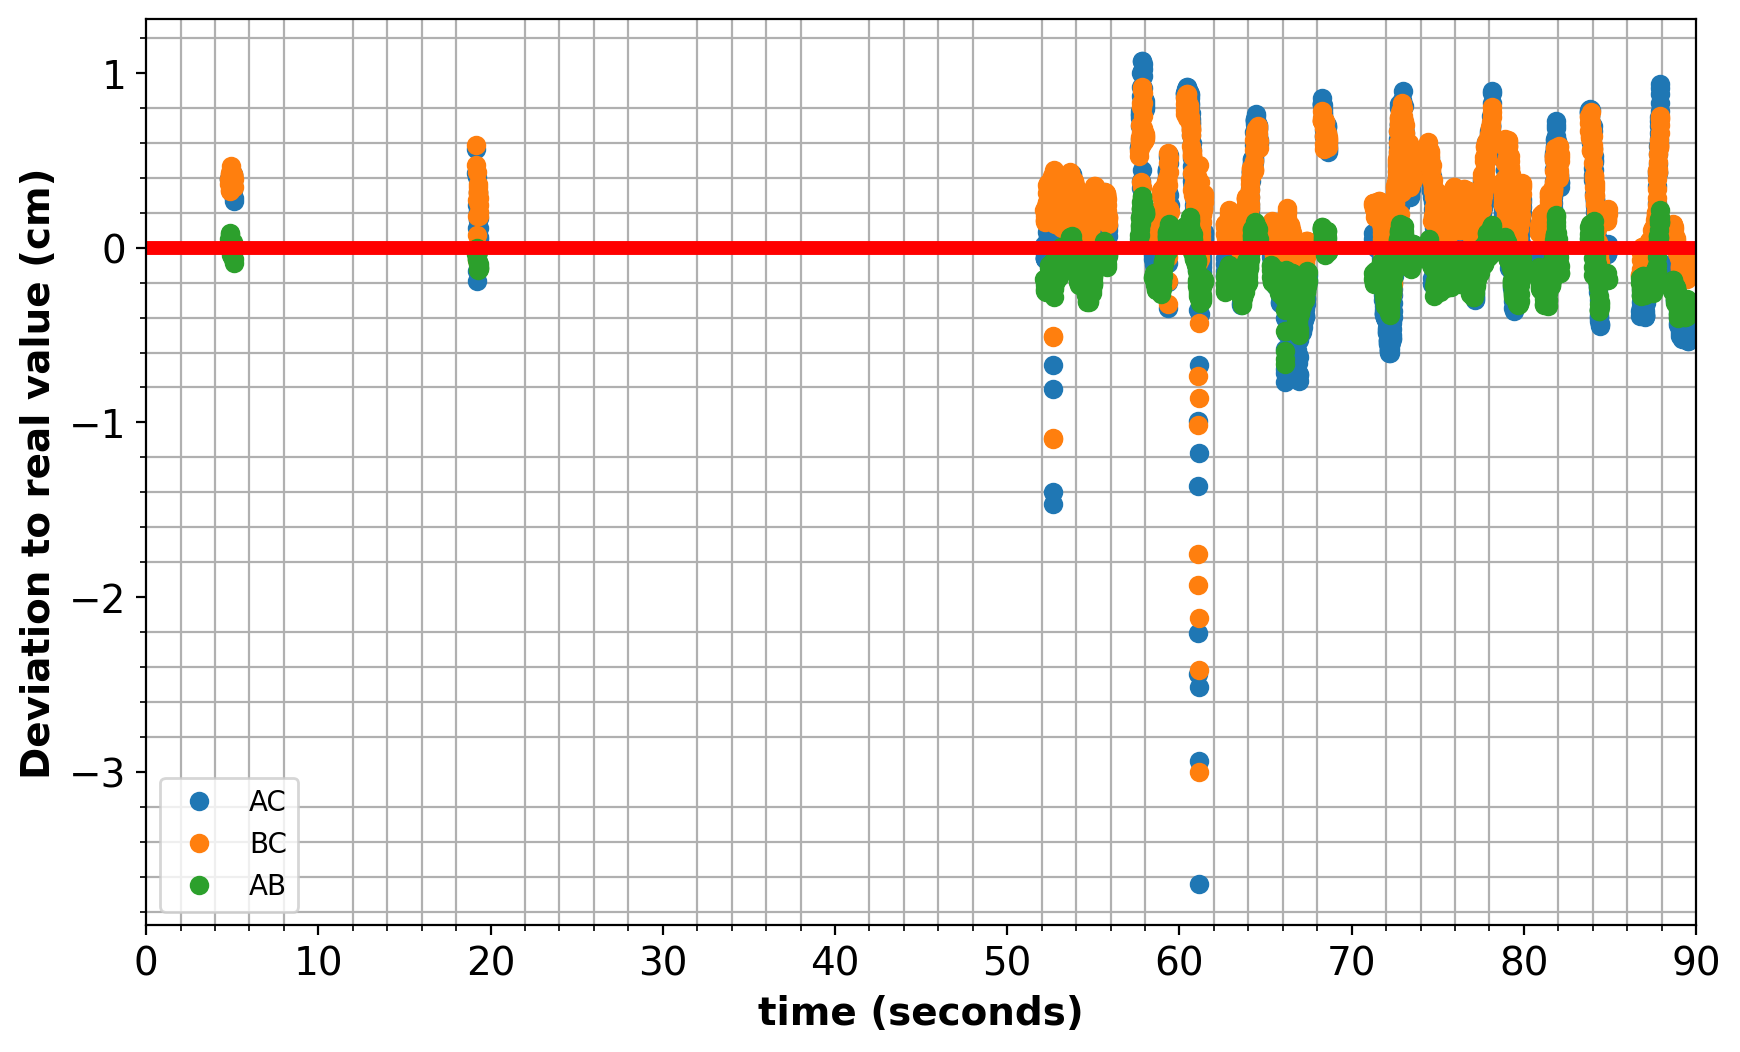

[INFO] Refining fundamental matrix estimation
Scale between real world and triang. point cloud is:  467.96
L_AC >> mean = 15.7692cm, std. dev = 0.3395cm, rms = 0.3465cm
L_AB >> mean = 5.3716cm, std. dev = 0.1321cm, rms = 0.1842cm
L_BC >> mean = 10.4193cm, std. dev = 0.2196cm, rms = 0.3103cm


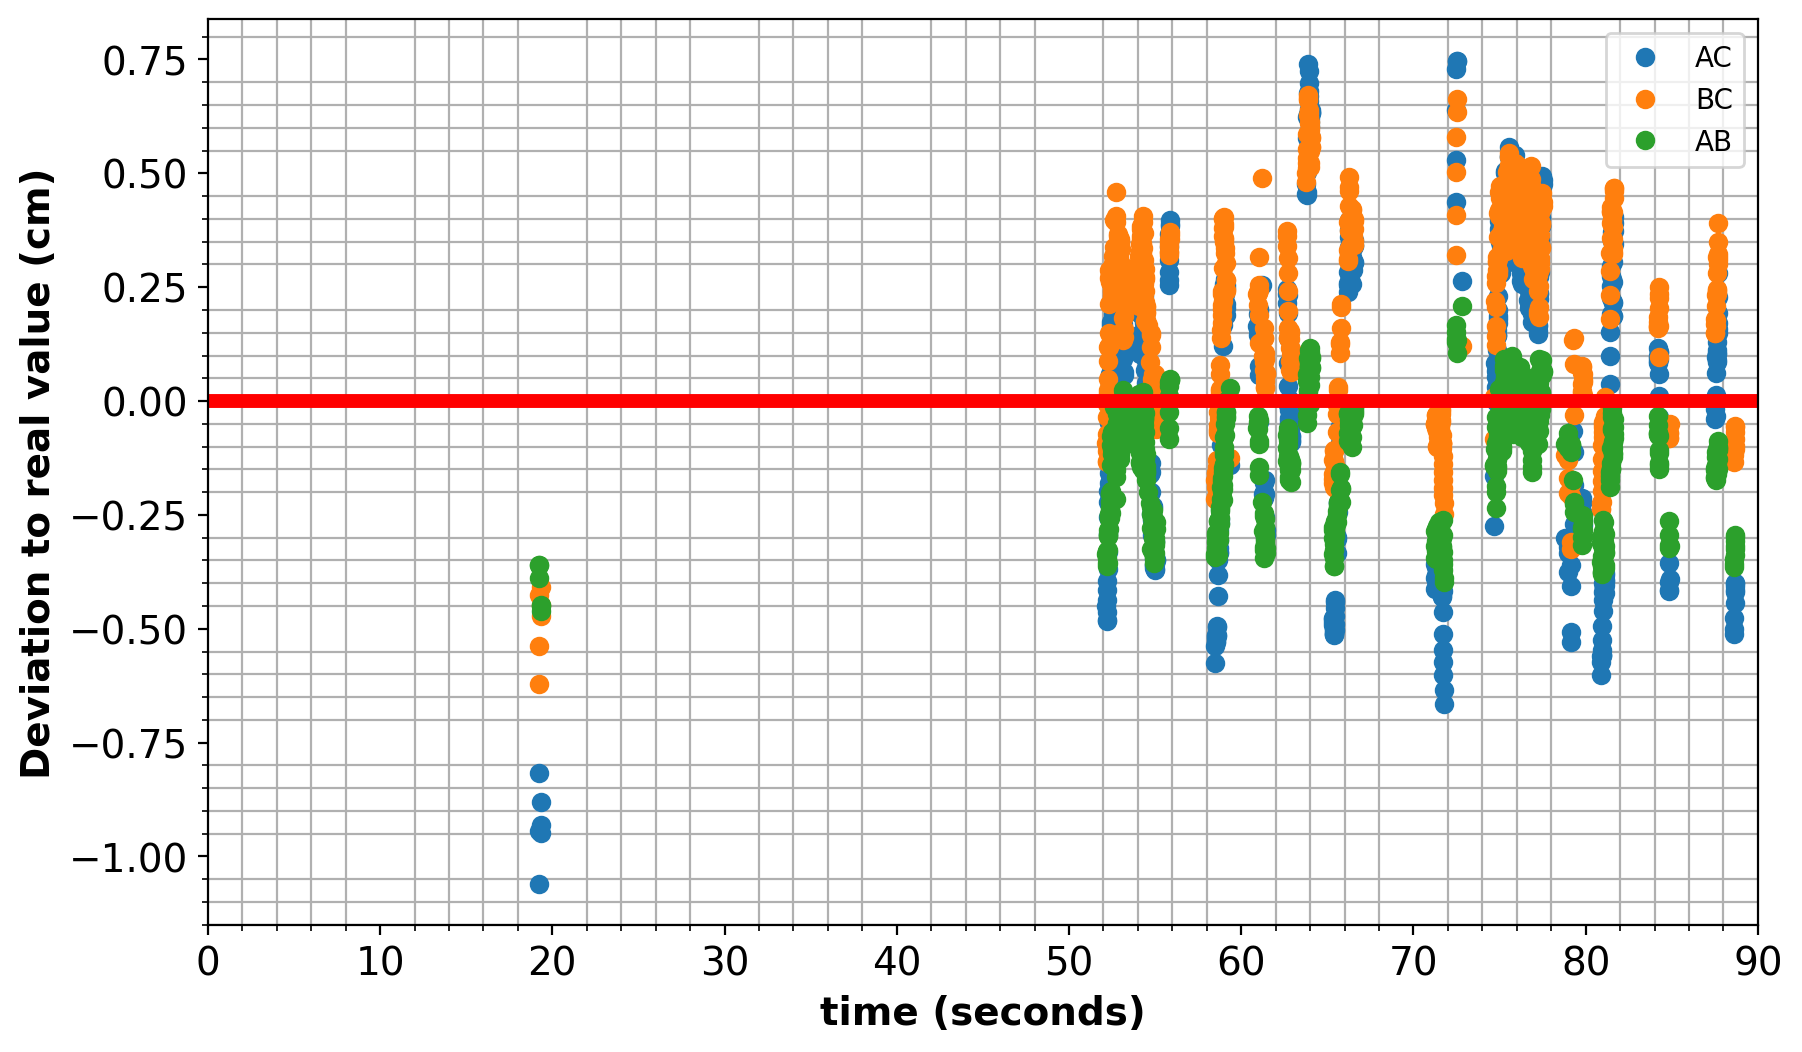

--


In [597]:
rotation,translation,scale,FMatrix,points3D_perPair = [np.identity(3)],[[[0., 0., 0.]]],[1],[],[]
allIdx,dataBundAdj = list(combinations(list(range(nCameras)),2)),[]
verbose = False
for [m,n] in allIdx:
    # compute valid time intersection for interpolation
    intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                        for first in timeIntervals[m] for second in timeIntervals[n]  
                        if max(first[0], second[0]) <= min(first[1], second[1])]
    dfInterp = np.zeros((int(recTime/step),2*6+1))
    dfInterp[:,-1] = np.linspace(0,recTime,int(recTime/step))
    for [beg,end] in intersections:
        for idx in [m,n]:
            validIdx = [i for i in range(0,dfOrig[idx].shape[0]) if beg<=dfOrig[idx][i,-1]<=end]
            coord,time = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
            if time.shape[0]<=2: continue
            lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
            if verbose: print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            if time.shape[0]<=2: continue
            ff = CubicSpline(time,coord,axis=0)
            if idx == m: dfInterp[tNew,0:6] = ff(tNew*step)
            else: dfInterp[tNew,6:12] = ff(tNew*step)
    # get data
    dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
    if dfInterp.shape[0] < 10: 
        print('[ERROR] no valid image intersection for cameras '+str(m)+' and '+str(n))        
        translation.append(np.array([]))
        rotation.append(np.array([]))
        scale.append(np.array([]))
        FMatrix.append(np.array([]))
        points3D_perPair.append(np.array([]))
        break
    centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)
    print('interpolated '+str(dfInterp.shape[0])+' images between cams '+str(m)+' and '+str(n))
    # get fundamental and essential matrices 
    print('[INFO] Computing fundamental and essential matrix between cameras '+str(m)+'-'+str(n))
    # get fundamental and essential matrices
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose=verbose)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): 
        print('no valid rotation matrix')     
        translation.append(np.array([]))
        rotation.append(np.array([]))
        scale.append(np.array([]))
        FMatrix.append(np.array([]))
        points3D_perPair.append(np.array([]))
        break
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R, t.T)))
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx,time_idx = 0,15.7,5.5,10.2,[],[],[],0,[],[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('Scale between real world and triang. point cloud is: ', lamb.round(2))
    print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    points3d_new,i,k= points3d*lamb,0,0
    for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
        L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
        valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
        if not valid: 
            i = i + 1
            false_idx.extend((k,k+1,k+2))
            time_idx.append(int(k/3))
        k+=3
    print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()
    # refining estimation
    print("[INFO] Refining fundamental matrix estimation")
    centroids1,centroids2,dfInterp=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0),np.delete(dfInterp,time_idx,axis=0)
    points3d = np.delete(points3d,false_idx,axis=0)    
    # bundle adjustment
    '''cameraParams = []
    for i in [m,n]: 
        K = cameraMat[i]
        if not len(cameraParams): cameraParams = np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(np.identity(3))[0].reshape(-1,3),np.zeros((1,3))))
        else: cameraParams=np.vstack((cameraParams,np.hstack((np.array([K[0][0],K[1][1],K[0][2],K[1][2]]).reshape(-1,4),Rodrigues(R)[0].reshape(-1,3),t.reshape(-1,3)))))
    x = np.hstack((cameraParams.ravel(), points3d.ravel()))
    nCam,points_2d = 2,np.vstack((centroids1,centroids2))
    cameraIdx = np.hstack((np.zeros(centroids1.shape[0]),np.ones(centroids2.shape[0])))
    pointIdx = np.hstack(([i for i in range(centroids1.shape[0])],[i for i in range(centroids2.shape[0])]))
    nPts = points3d.shape[0]
    r = reprojectionError(x,nCam,points_2d,cameraIdx,pointIdx)
    A = bundle_adjustment_sparsity(nCam,nPts,cameraIdx,pointIdx)    
    res = least_squares(reprojectionError, x, jac_sparsity=A, verbose=0, x_scale='jac', ftol=1e-4, method='trf',
                        args=(nCam,points_2d,cameraIdx,pointIdx))
    rot,tra,K = [],[],[]
    for cameraParams in res.x[0:20].reshape(2,10):
        R,t = cameraParams[4:7].reshape(-1,3),cameraParams[7:10].reshape(-1,3)
        camCoef = cameraParams[0:4]
        K.append(np.array([[camCoef[0],0,camCoef[2]],[0,camCoef[1],camCoef[3]],[0,0,1]]))
        rot.append(Rodrigues(R)[0])
        tra.append(t) 
    P1,P2 = np.matmul(K[0], np.hstack((rot[0], tra[0].T))),np.matmul(K[1], np.hstack((rot[1], tra[1].T)))'''
    # get fundamental and essential matrices refinment
    F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2),verbose = 0)
    E = np.matmul(cameraMat[n].T, np.matmul(F, cameraMat[m]))
    if verbose: print("\nEssenc. Mat.\n", E.round(4))
    # decompose to rotation and translation between cameras
    R, t = decomposeEssentialMat(E, cameraMat[m], cameraMat[n], np.array(centroids1), np.array(centroids2))
    if np.any(np.isnan(R)): 
        print('no valid rotation matrix')
        translation.append(np.array([]))
        rotation.append(np.array([]))
        scale.append(np.array([]))
        FMatrix.append(np.array([]))
        points3D_perPair.append(np.array([]))
        break
    else:
        if verbose:
            print("\nRot. Mat.\n", R.round(4))
            print("\nTrans. Mat.\n", t.round(4))
    P1,P2 = np.hstack((cameraMat[m], [[0.], [0.], [0.]])),np.matmul(cameraMat[n], np.hstack((R,t.T)))
    ###
    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
    points3d = (points4d[:3, :]/points4d[3, :]).T
    if points3d[0, 2] < 0: points3d = -points3d
    cameraIdx = np.ones((dfInterp.shape[0],2))*[m,n]
    dataBundAdj.append(np.hstack((dfInterp,points3d.reshape(-1, 9),cameraIdx)))
    tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,5.5,10.2,[],[],[],0,[]
    # compute sdt deviation and plot beautiful stuff
    for [A, B, C] in points3d.reshape([-1, 3, 3]):
        L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
        tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
        k = k + 3
        L_AC_vec.append(L_rec_AC)
        L_BC_vec.append(L_rec_BC)
        L_AB_vec.append(L_rec_AB)   
    lamb = tot/k
    print('Scale between real world and triang. point cloud is: ', lamb.round(2))
    print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
    print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
    print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) + "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
        "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
    fig = plt.figure(figsize=(10, 6), dpi=200)
    L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
    plt.plot(dfInterp[:,-1],L_AC_vec_plot, 'o', label="AC")
    plt.plot(dfInterp[:,-1],L_BC_vec_plot, 'o', label="BC")
    plt.plot(dfInterp[:,-1],L_AB_vec_plot, 'o', label="AB")
    plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
    plt.grid()
    plt.xlabel("time (seconds)",fontsize=14, fontweight='bold')
    plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
    plt.legend()
    ax = fig.axes
    ax[0].minorticks_on()
    plt.grid(which='both')
    plt.xlim(0,recTime)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.draw()
    plt.show()
    if (n-m)==1:
        translation.append(t)
        rotation.append(R)
        scale.append([lamb])
        FMatrix.append(F)
        points3D_perPair.append(points3d)
    # epipolar lines    
    '''img1,img2,n = np.ones((720,960))*255,np.ones((720,960))*255,0
    pts1,pts2 = np.int32(centroids1[n:n+3].reshape(-1,2)),np.int32(centroids2[n:n+3].reshape(-1,2))
    lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(20, 16),dpi=100)
    plt.subplot(121),plt.imshow(img5.astype(np.uint8))
    plt.subplot(122),plt.imshow(img3.astype(np.uint8))
    plt.show()'''
    print('--')


In [522]:
def reproject(points3d,cameraParams):
    """Convert 3-D points to 2-D by projecting onto images."""
    camCoef,rod,t,R  = cameraParams[:,0:4],cameraParams[:,4:7].reshape(-1,3,1),cameraParams[:,7:10].reshape(-1,3,1),[]
    for r in rod: R.append(Rodrigues(r)[0])
    R = np.array(R).reshape(-1,3,3)
    nPts = camCoef.shape[0]
    K = np.transpose(np.array([[camCoef[:,0],np.zeros(nPts),camCoef[:,2]],
                  [np.zeros(nPts),camCoef[:,1],camCoef[:,3]], 
                  [np.zeros(nPts),np.zeros(nPts),np.ones(nPts)]]),(2,0,1))            
    P = np.matmul(K,np.dstack((R, t)))
    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))
    newPts = np.matmul(P,newPts3D)
    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])
    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)

def reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx):
    """Compute residuals. """
    cameraParams = params[:nCameras*10].reshape(-1, 10)
    points_3d = params[nCameras*10:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)])
    return (points_proj - points_2d).ravel()

from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

def bundle_adjustment_sparsity(nCameras,nPts,camIdx,pointIdx):
    m = camIdx.size*2
    n = nCameras*10+nPts*3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camIdx.size)
    for s in range(4,10):
        A[2*i,camIdx*10+s] = 1
        A[2*i+1,camIdx*10+s] = 1
    for s in range(3):
        A[2*i,nCameras*10+pointIdx*3+s] = 1
        A[2*i+1,nCameras*10+pointIdx*3+s] = 1
    return A
     

In [520]:
## using sum
'''def reproject(points3d,cameraParams):
    """Convert 3-D points to 2-D by projecting onto images."""
    camCoef,R,t = cameraParams[:,0:4],cameraParams[:,4:13].reshape(-1,3,3),cameraParams[:,13:16].reshape(-1,3,1)
    nPts = camCoef.shape[0]
    K = np.transpose(np.array([[camCoef[:,0],np.zeros(nPts),camCoef[:,2]],
                  [np.zeros(nPts),camCoef[:,1],camCoef[:,3]], 
                  [np.zeros(nPts),np.zeros(nPts),np.ones(nPts)]]),(2,0,1))            
    P = np.matmul(K,np.dstack((R, t)))
    newPts3D = np.transpose(np.hstack((points3d,np.ones((points3d.shape[0],1)))).reshape(-1,1,4),(0,2,1))
    newPts = np.matmul(P,newPts3D)
    pts2D = newPts[:,0:2,:]/newPts[:,2,:].reshape(-1,1,newPts.shape[-1])
    return np.transpose(pts2D,(0,2,1)).reshape(-1,2)

def reprojectionError(params,nCameras,points_2d,cameraIdx,pointIdx):
    """Compute residuals. """
    cameraParams = params[:nCameras*16].reshape(-1, 16)
    points_3d = params[nCameras*16:].reshape(-1, 3)
    points_proj = reproject(points_3d[pointIdx.astype(int)], cameraParams[cameraIdx.astype(int)])
    error = np.linalg.norm(points_proj - points_2d, axis=1)
    return np.sum(error.reshape(-1,3),axis=1).ravel()

from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

def bundle_adjustment_sparsity(nCameras,nPts,camIdx,pointIdx):
    m = int(camIdx.size/3)
    n = nCameras*16+nPts*3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(int(camIdx.size/3))
    camIdxNew = camIdx.reshape(-1,3)[:,0]
    pointIdxNew = pointIdx.reshape(-1,3)[:,0]
    for s in range(4,16):
        A[i,camIdxNew*16+s] = 1
    for s in range(3):
        A[i,nCameras*16+pointIdxNew*3+s] = 1
        A[i,nCameras*16+pointIdxNew*3+s+3] = 1
        A[i,nCameras*16+pointIdxNew*3+s+6] = 1
    return A'''
     

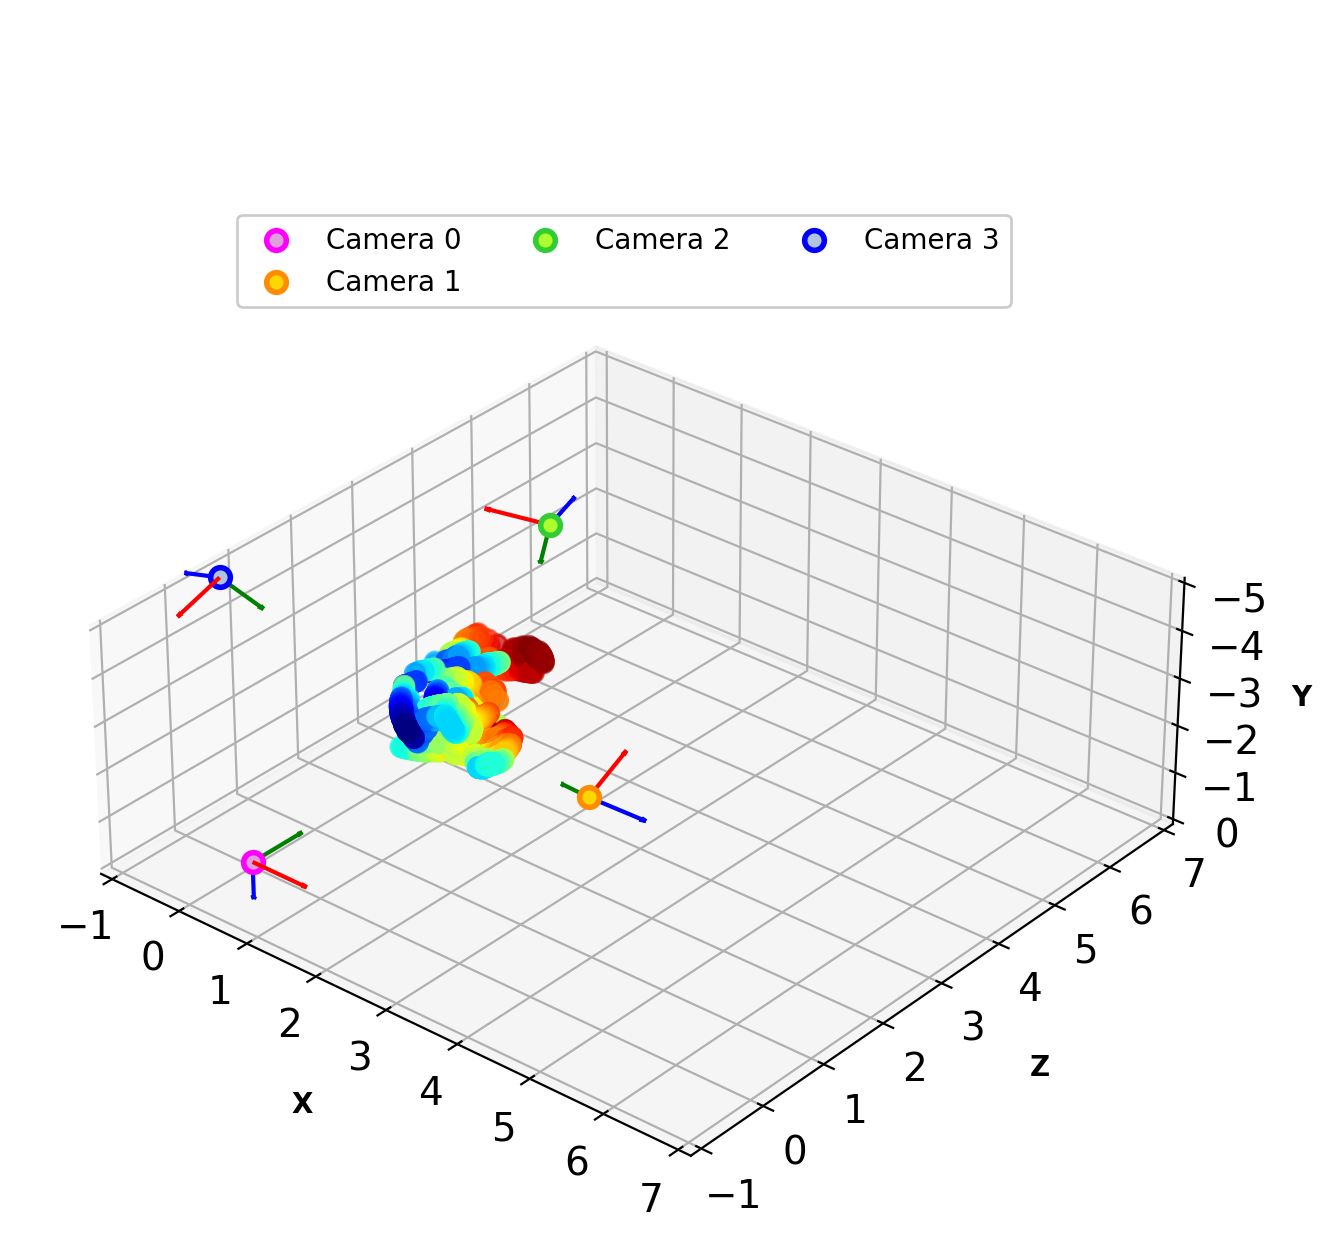

In [15]:
# plot 3d map
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 7)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 7)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
pose3d,R_all,t_all = [],[],[]
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]

for j in range(nCameras):
    # plot camera
    k = 0.8
    x,y,z,t_new,R_new = np.array([k, 0, 0]), np.array([0, k, 0]),np.array([0, 0, k]),[0.,0.,0.],np.identity(3)
    for i in np.flip(range(j+1)):
        t,R,lamb = np.array(translation[i][0]).reshape(-1,3),np.array(rotation[i]),scale[i]
        t_new = np.matmul(-t, R)*lamb/100 + np.matmul(t_new,R)
        R_new = np.matmul(R,R_new)
    R_all.append(R_new)
    t_all.append(t_new)
    x,y,z = np.matmul(R_new.T, x),np.matmul(R_new.T, y),np.matmul(R_new.T, z)
    ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(t_new[0][0], t_new[0][2], t_new[0][1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera '+str(j))
    if j:
        t_new,R_new = [0.,0.,0.], np.identity(3)
        for i in np.flip(range(j)):
            t,R,lamb = np.array(translation[i][0]),np.array(rotation[i]),scale[i]
            t_new = np.matmul(-t, R)*lamb/100 + np.matmul(t_new,R)
            R_new = np.matmul(R,R_new)
        points3d= points3D_perPair[j-1]*scale[j]/100
        points3d_new = np.matmul(R_new.T,points3d.T).T+t_new
        ax.scatter(points3d_new[:, 0], points3d_new[:, 2], points3d_new[:, 1], c=points3d_new[:, 2], cmap=cmhot,s = 50)
        if not len(pose3d): pose3d = np.copy(points3d_new)
        else: pose3d= np.vstack((pose3d,points3d_new))

# plot commands
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.draw()
plt.show()

#### Ground plane

In [16]:
def isEqual4(pt,tol=5):
    A,B,C,D = pt[0],pt[1],pt[2],pt[3]
    AB,AC,BC = np.linalg.norm(A-B),np.linalg.norm(A-C),np.linalg.norm(C-B)
    AD,BD,CD = np.linalg.norm(A-D),np.linalg.norm(B-D),np.linalg.norm(C-D)
    return min(AB,AC,BC,AD,BD,CD)<tol

def getEpilineCoef(pts,F):
    [a,b,c]=np.matmul(F,np.hstack((pts,1))) #ax+by+c=0
    return [a,b,c]/(np.sqrt(pow(a,2)+pow(b,2)))

def getDistance2Line(lines,pts):
    pts,out,lines = np.copy(pts).reshape(-1,2),[],np.copy(lines).reshape(-1,3)
    for [a,b,c] in lines:
        for [x,y] in pts: out.append(abs(a*x+b*y+c)/np.sqrt(np.sqrt(pow(a,2)+pow(b,2))))
    return np.array(out)<5,np.array(out)    

def findPlane(A,C,D):
    x1,y1,z1 = A
    x2,y2,z2 = C
    x3,y3,z3 = D
    a1,b1,c1 = x2-x1,y2-y1,z2-z1
    a2,b2,c2 = x3-x1,y3-y1,z3-z1
    a,b,c = b1*c2-b2*c1,a2*c1-a1*c2,a1*b2-b1*a2
    d=(-a*x1-b*y1-c*z1)
    return np.array([a,b,c,d])

def getOrderPerEpiline(coord1,coord2,nMarkers,F,verbose = 0):
    # get data
    pts1,pts2,orderSecondFrame = np.copy(coord1).reshape(-1,2),np.copy(coord2).reshape(-1,2),np.ones(nMarkers,dtype=np.int8)*-1
    epilines = np.zeros((nMarkers,3))
    choosenIdx,allDists = [],[]
    for i in range(nMarkers):
        epilines[i] = getEpilineCoef(pts1[i],F)        
    allPermuationsOf4 = np.array(list(permutations(list(range(0,nMarkers)))))
    # get all possible distances between point/line
    for idx2 in allPermuationsOf4:
        newPts2,dist = pts2[idx2],0
        for k in range(nMarkers):
            _,aux= getDistance2Line(epilines[k],newPts2[k])
            dist+=aux
        allDists.append(dist)
    # get minimum distance
    minDist = min(allDists)
    # get all idx with 1 pixels distance from the mininum distance combination
    choosenIdx = allPermuationsOf4[np.where(allDists<=minDist+1)[0]]
    # id there are more than 1 combination possible, find ambiguous blobs
    if len(choosenIdx)>1:
        # initiate variables
        allCombinationsOf2 = np.array(list(combinations(list(range(0,len(choosenIdx))),2)))
        mask = np.ones(nMarkers,dtype=np.bool)
        # get common idx from all ambiguous combinations
        for idx in allCombinationsOf2:
            nowMask = np.equal(choosenIdx[idx[0]],choosenIdx[idx[1]])
            mask*=nowMask
        # invert mask to find the blobs that differs in each image
        mask = np.invert(mask)
        idxAmbiguous1,idxAmbiguous2 = np.where(mask)[0],choosenIdx[0][mask]
        collinearPts1,collinearPts2 = pts1[idxAmbiguous1],pts2[idxAmbiguous2]
        # sort per X
        if np.all(np.diff(np.sort(collinearPts2[:,0]))>2) and np.all(np.diff(np.sort(collinearPts1[:,0]))>2):
            order1,order2 = np.argsort(collinearPts1[:,0]),np.argsort(collinearPts2[:,0])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        else: # sort per Y
            order1,order2 = np.argsort(collinearPts1[:,1]),np.argsort(collinearPts2[:,1])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        orderSecondFrame = choosenIdx[0]
        orderSecondFrame[idx1.astype(int)] = idx2.astype(int)
    else: orderSecondFrame = choosenIdx[0]

    ## verbose
    if verbose:
        pts2 = np.copy(pts2[orderSecondFrame])
        img1,img2 = np.ones((720,960))*255,np.ones((720,960))*255
        lines1 = computeCorrespondEpilines(np.int32(pts2).reshape(-1,1,2), 2,F)
        lines1 = lines1.reshape(-1,3)
        img5,_ = drawlines(img1,img2,lines1,np.int32(pts1),np.int32(pts2))
        lines2 = computeCorrespondEpilines(np.int32(pts1).reshape(-1,1,2), 1,F)
        lines2 = lines2.reshape(-1,3)
        img3,_ = drawlines(img2,img1,lines2,np.int32(pts2),np.int32(pts1))
        plt.figure(figsize=(20, 16),dpi=100)
        plt.subplot(121),plt.imshow(img5)
        plt.subplot(122),plt.imshow(img3)
        plt.show()
    return orderSecondFrame

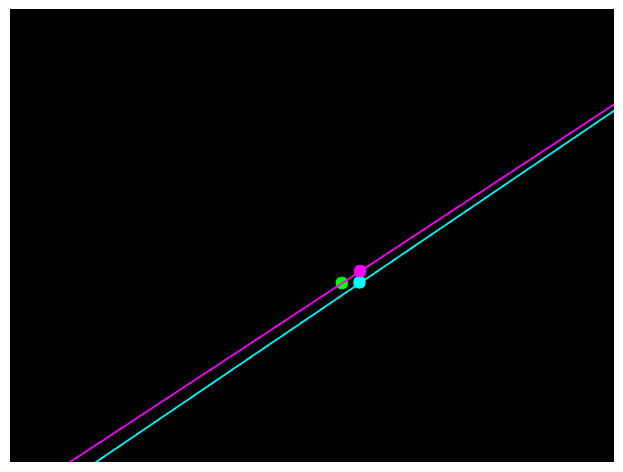

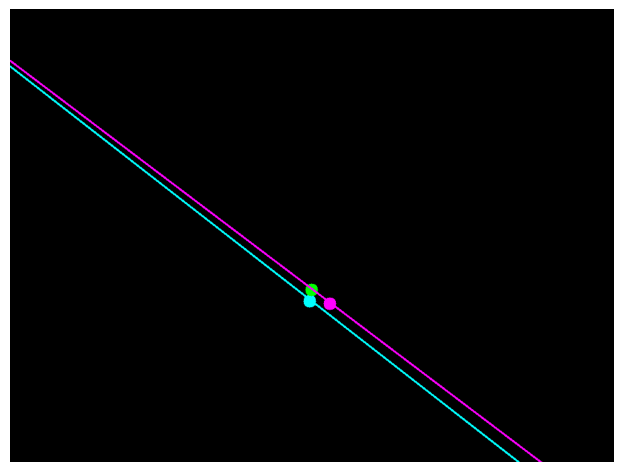

In [17]:
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/20Jun/camGround.csv', delimiter=',')
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,255,255),(0,255,0),(255,0,255),(255,0,255)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,2)
        img1 = circle(img1,tuple(pt1),10,color,-1)
        img2 = circle(img2,tuple(pt2),10,color,-1)
        i+=1
    return img1,img2

while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    idx = int(line[8])
    # get points
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    # save points
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    # update variables
    i+=1
    counter[idx]+=1
    # do I have enough points?
    if np.all(counter>0): break

F = FMatrix[0]
R,t,lamb = rotation[1],translation[1].reshape(-1,3),scale[1]
pts1,pts2 = dfOrig[0][0:6].reshape(-1,2),dfOrig[1][0:6].reshape(-1,2)
orderSecondFrame = getOrderPerEpiline(pts1,pts2,3,np.copy(F))
pts2 = np.copy(pts2[orderSecondFrame])
pts1,pts2 = np.int32(pts1),np.int32(pts2)
# verbose
from cv2 import line
img1,img2 = np.zeros((720,960)),np.zeros((720,960))
lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,_ = drawlines(img1,img2,lines1,pts1,pts2)
lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,_ = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(8, 6),dpi=100)
plt.imshow(img5.astype(np.uint8)) 
plt.axis('off') 
#plt.savefig('epi1.png', bbox_inches='tight')
plt.show()
plt.figure(figsize=(8, 6),dpi=100)
plt.imshow(img3.astype(np.uint8))
plt.axis('off') 
#plt.savefig('epi2.png', bbox_inches='tight')
plt.show()

In [18]:
# tiangulate
P1,P2 = np.hstack((cameraMat[0], [[0.], [0.], [0.]])),np.matmul(cameraMat[1], np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(pts1)),myProjectionPoints(np.array(pts2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
plane = findPlane(points3d[0]*lamb/100,points3d[1]*lamb/100,points3d[2]*lamb/100)
if np.any(plane[0:3]<0): plane = findPlane(points3d[0]*lamb/100,points3d[2]*lamb/100,points3d[1]*lamb/100)

In [19]:
[a,b,c,d]=plane
v,k=np.array([a,b,c]),np.array([0,1,0])
cosPhi = np.dot(v,k)/(np.linalg.norm(v)*np.linalg.norm(k))
[u1,u2,u3] = np.cross(v,k)/np.linalg.norm(np.cross(v,k))
sinPhi = np.sqrt(1-pow(cosPhi,2))
R_plane = np.array([
        [cosPhi+u1*u1*(1-cosPhi),u1*u2*(1-cosPhi),u2*sinPhi],
        [u1*u2*(1-cosPhi),cosPhi+u2*u2*(1-cosPhi),-u1*sinPhi],
        [-u2*sinPhi,u1*sinPhi,cosPhi]])
[A,B,C] = np.matmul(np.array([a,b,c]),R_plane.T)
newPlane = np.array([A,B,C])

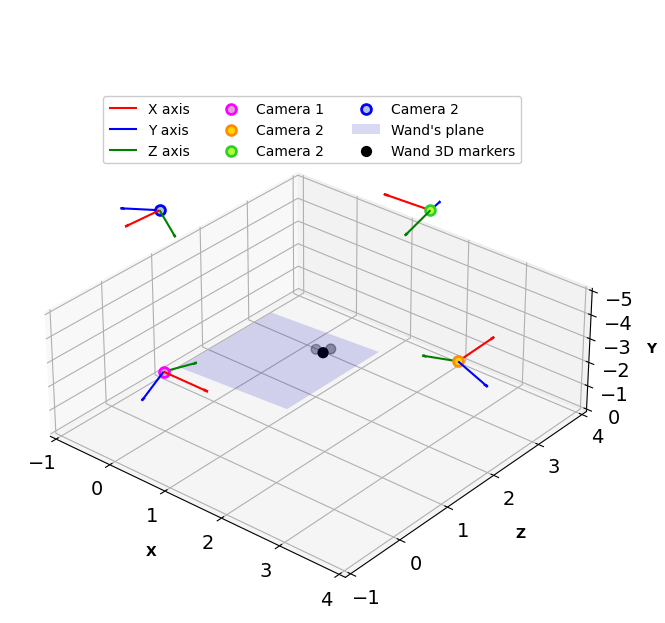

In [21]:
# tiangulate
points3dNew = points3d*lamb/100
# configure 3d map
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
colours = [['fuchsia','plum'],['darkorange','gold'],['limegreen','greenyellow'],['blue','lightsteelblue']]
# plot first camera
scale = 0.8
cam1Pts = np.array([[0,d/b,0],
                    [scale, 0, 0],
                    [0, scale, 0],
                    [0, 0, scale]])
cam1PtsNew = np.matmul(R_plane,cam1Pts.T).T
[cam1Root,x,y,z]=cam1PtsNew
zDisplacement = cam1PtsNew[0,2]
cam1Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r", label = 'X axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b", label = 'Y axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g", label = 'Z axis')
ax.scatter(cam1Root[0],cam1Root[2],cam1Root[1], s=50, edgecolor=colours[0][0], facecolor=colours[0][1], linewidth=2, label = 'Camera 1')
# plot further cameras camera
for j in range(1,nCameras):
    x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
    x,y,z = np.matmul(R_all[j].T, x),np.matmul(R_all[j].T, y),np.matmul(R_all[j].T, z)
    t_aux = np.copy(t_all[j]).reshape(-1)+[0,d/b,0]
    cam2Pts = np.array([t_aux.T,x,y,z])
    cam2PtsNew = np.matmul(R_plane,cam2Pts.T).T
    [cam2Root,x,y,z]=cam2PtsNew
    cam2Root+=[0,0,-zDisplacement]
    x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
    ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(cam2Root[0],cam2Root[2],cam2Root[1], s=50, edgecolor=colours[j][0], facecolor=colours[j][1], linewidth=2,  label = 'Camera 2')

# new plane
x,z = np.linspace(-1,1,30),np.linspace(3,5,10)
X,Z = np.meshgrid(x,z)
Y=(-newPlane[0]*X -newPlane[2]*Z)/newPlane[1]
surf = ax.plot_surface(X,Z-zDisplacement,Y,color='b',alpha=.15,label="Wand's plane")
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
ax.scatter(points3dNew[:, 0], points3dNew[:, 2]-zDisplacement, points3dNew[:, 1], color='black',s = 50,label='Wand 3D markers')
# axis setup
ax.view_init(elev=30, azim=-50) 
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
#plt.savefig('withRot_2.png', bbox_inches='tight')
plt.draw()
plt.show()

#### Test

In [509]:
def getDistance2Line(lines,pts):
    pts,out,lines = np.copy(pts).reshape(-1,2),[],np.copy(lines).reshape(-1,3)
    for [a,b,c] in lines:
        for [x,y] in pts: out.append(abs(a*x+b*y+c)/np.sqrt(np.sqrt(pow(a,2)+pow(b,2))))
    return np.array(out)<5,np.array(out) 

def drawlines(img1,img2,lines,pts1,pts2):    
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0),(255,0,255)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        putText(img1,str(i),tuple(pt1-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        img2 = circle(img2,tuple(pt2),5,color,-1)
        putText(img2,str(i),tuple(pt2-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        i+=1
    return img1,img2


In [510]:
def getOrderPerEpiline(coord1,coord2,nMarkers,verbose = 0):
    pts1,pts2,orderSecondFrame = np.copy(coord1).reshape(-1,2),np.copy(coord2).reshape(-1,2),np.ones(nMarkers,dtype=np.int8)*-1
    epilines = np.zeros((nMarkers,3))
    choosenIdx,allDists = [],[]
    # choose order per epiline
    for i in range(nMarkers):
        epilines[i] = getEpilineCoef(pts1[i],F)        
    allPermuationsOf4 = np.array(list(permutations(list(range(0,4)))))
    for idx2 in allPermuationsOf4:
        newPts2,dist = pts2[idx2],0
        for k in range(nMarkers): 
            _,aux= getDistance2Line(epilines[k],newPts2[k])
            dist+=aux
        allDists.append(dist)
    minDist = min(allDists)
    choosenIdx = allPermuationsOf4[np.where(allDists<=minDist+1)[0]]
    if len(choosenIdx)>1:
        allCombinationsOf2 = np.array(list(combinations(list(range(0,len(choosenIdx))),2)))
        mask = np.ones(nMarkers,dtype=np.bool)
        for idx in allCombinationsOf2:
            nowMask = np.equal(choosenIdx[idx[0]],choosenIdx[idx[1]])
            mask*=nowMask
        mask = np.invert(mask)
        idxAmbiguous1,idxAmbiguous2 = np.where(mask)[0],choosenIdx[0][mask]
        collinearPts1,collinearPts2 = pts1[idxAmbiguous1],pts2[idxAmbiguous2]
        if np.all(np.diff(np.sort(collinearPts2[:,0]))>2) and np.all(np.diff(np.sort(collinearPts1[:,0]))>2):
            order1,order2 = np.argsort(collinearPts1[:,0]),np.argsort(collinearPts2[:,0])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        else:
            order1,order2 = np.argsort(collinearPts1[:,1]),np.argsort(collinearPts2[:,1])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        orderSecondFrame = choosenIdx[0]
        orderSecondFrame[idx1.astype(int)] = idx2.astype(int)
    else: orderSecondFrame = choosenIdx[0]
    
    ## verbose
    if verbose:
        pts2 = np.copy(pts2[orderSecondFrame])
        img1,img2 = np.ones((720,960))*255,np.ones((720,960))*255
        lines1 = computeCorrespondEpilines(np.int32(pts2).reshape(-1,1,2), 2,F)
        lines1 = lines1.reshape(-1,3)
        img5,_ = drawlines(img1,img2,lines1,np.int32(pts1),np.int32(pts2))
        lines2 = computeCorrespondEpilines(np.int32(pts1).reshape(-1,1,2), 1,F)
        lines2 = lines2.reshape(-1,3)
        img3,_ = drawlines(img2,img1,lines2,np.int32(pts2),np.int32(pts1))
        plt.figure(figsize=(20, 16),dpi=100)
        plt.subplot(121),plt.imshow(img5)
        plt.subplot(122),plt.imshow(img3)
        plt.show()
    return orderSecondFrame

#import time
#start=time.time()
#print(getOrderPerEpiline(dfOrig[0][0,0:8],dfOrig[1][0,0:8],4,0))
#print(time.time()-start)

In [511]:
def getTheClosest(coordNow, prev):
    centerCoord,prevCenterCoord = np.copy(coordNow).reshape(-1,2),np.copy(prev).reshape(-1,2)
    newOrder,nMarkers = np.ones(centerCoord.shape[0],dtype=np.int8)*-1,centerCoord.shape[0]
    for i in range(nMarkers):
        if newOrder[i] == -1:
            pt = prevCenterCoord[i]        
            distNow = np.linalg.norm(centerCoord-pt,axis=1)
            retNow = distNow < 5
            if np.sum(retNow) == 1: newOrder[i] = np.argmin(distNow)
            else:              
                allPermuationsOf4,allDists = np.array(list(permutations(list(range(0,4))))),[]
                for idx in allPermuationsOf4:
                    newPts,dist = centerCoord[idx],0
                    for k in range(nMarkers): 
                        aux= np.linalg.norm(prevCenterCoord[k]-newPts[k])
                        dist+=aux
                    allDists.append(dist)
                minDist = np.argmin(allDists)
                choosenIdx = allPermuationsOf4[minDist]
                return choosenIdx
    return newOrder

import time

In [512]:
def myInterpolate(coord,ts,step):
    if not len(ts): return [],[]
    lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
    tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
    ff = CubicSpline(ts,coord,axis=0)
    return ff(tNew*step),tNew

In [513]:
def myOtherIdx(n,nCameras):
    allIdx = np.array([i for i in range(nCameras)])
    return np.array([i for i in allIdx if i != n ])

PMatrices = []
for i in range(nCameras):   
    PMatrices.append(np.matmul(cameraMat[i], np.hstack((rotation[i], np.array(translation[i]).T))))

In [514]:
rectime = 60
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/7Jun/camTest_50cmSquare_only4Blobs.csv', delimiter=',')
#dfCSV = np.genfromtxt('camCalib.csv',delimiter=',')
counter,i,lastTime = np.zeros(nCameras,dtype=np.int32),0,np.zeros(nCameras,dtype=np.int32)
missed,invalid,swap = np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32),np.zeros(nCameras,dtype=np.int32)
lastImgNumber = np.zeros(nCameras,dtype=np.int32)
intervals,lastTnew = [],[]
dfOrig,nPrevious,warmUp = [],3,10 # warm up> n previous
verbose,needsOrder = False,True
points3d = []
for k in range(nCameras):
    dfOrig.append([])
    intervals.append([])
    lastTnew.append([])

dfInterp = np.zeros((int(recTime/step),nCameras*8+1))
dfInterp[:,-1] = np.linspace(0,recTime,int(recTime/step))
timeArray = []

while i!=dfCSV.shape[0]:
    start = time.time()
    line = dfCSV[i]
    idx = int(line[10])
    # get points
    undCoord,timeNow,imgNumber = line[0:8].reshape(-1,2),line[8],line[9]
    i+=1
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(timeNow-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            # discard image if resert is done and no ordering has been set
            if verbose: print('reseting at camera', idx,', counter',counter[idx],',',timeNow/1e6,'s')
            prev,needsOrder = [],True
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:8]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:8]).reshape(-1,2)
            newOrder = getTheClosest(undCoord.reshape(-1,2),prev.reshape(-1,2))
            undCoord = np.copy(undCoord[newOrder])
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = timeNow,imgNumber,0    
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(8),timeNow))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(8),timeNow))))
    counter[idx]+=1
    # interpolate
    if np.all(counter):
        if needsOrder:
            # get is there are enough points at the valid interval
            if np.all(counter-[intervals[0][-1],intervals[1][-1]]>=nPrevious):
                if verbose: print('in storage',counter-[intervals[0][-1],intervals[1][-1]])
                # see if there are intersection between arrays
                ts1,ts2 = dfOrig[0][intervals[0][-1]:counter[0],8]/1e6,dfOrig[1][intervals[1][-1]:counter[1],8]/1e6
                validIdx1 = [k for k in range(0,len(ts1)) if max(ts1[0], ts2[0])-0.01<=ts1[k]<=min(ts1[-1], ts2[-1])+0.01]
                validIdx2 = [k for k in range(0,len(ts2)) if max(ts1[0], ts2[0])-0.01<=ts2[k]<=min(ts1[-1], ts2[-1])+0.01]
                # if there is intersection, get order
                if len(validIdx1) and len(validIdx2):
                    ts1,ts2 = np.copy(ts1[validIdx1]),np.copy(ts2[validIdx2])
                    if ts1.shape[0]<2 or ts2.shape[0]<2: continue
                    coord1,coord2 = dfOrig[0][intervals[0][-1]:counter[0],0:8],dfOrig[1][intervals[1][-1]:counter[1],0:8]
                    coord1,coord2 = np.copy(coord1[validIdx1]),np.copy(coord2[validIdx2])
                    # get interpolated data
                    interp1,tNew1 = myInterpolate(coord1,ts1,step)
                    interp2,tNew2 = myInterpolate(coord2,ts2,step)
                    if not len(interp1) or not len(interp2): continue
                    # get common idx
                    interpolateIdx1,interpolateIdx2 = np.argmax(np.in1d(tNew1, tNew2)),np.argmax(np.in1d(tNew2, tNew1))
                    orderSecondFrame = getOrderPerEpiline(interp1[interpolateIdx1],interp2[interpolateIdx2],4,0)
                    # get interval to rearrange
                    idxInvalid = np.argmin(counter-[intervals[0][-1],intervals[1][-1]])
                    beg = [k for k in range(intervals[1][-1],counter[1]) if dfOrig[idxInvalid][intervals[idxInvalid][-1],8]-0.01<=dfOrig[1][k,8]][0]
                    if verbose:print('rearranging interval',[beg,counter[1]-1], 'to', orderSecondFrame)
                    # flip blobs
                    for k in range(beg,counter[1]):
                        dfOrig[1][k,0:8] = np.copy(dfOrig[1][k,0:8].reshape(-1,2)[orderSecondFrame].reshape(-8))
                    needsOrder=False
        if np.all(counter-[intervals[0][-1],intervals[1][-1]]>=warmUp): 
            coord,ts = dfOrig[idx][(counter[idx]-warmUp):counter[idx],0:8],dfOrig[idx][(counter[idx]-warmUp):counter[idx],8]/1e6
            if not len(ts): continue
            lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
            if lastTnew[idx]:
                if lowBound<lastTnew[idx]: lowBound = lastTnew[idx]+1
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            ff = CubicSpline(ts,coord,axis=0)
            dfInterp[tNew,int(idx*8):int(idx*8+8)] = ff(tNew*step)
            lastTnew[idx],otherIdx_list = tNew[-1],myOtherIdx(idx,nCameras)
            otherIdx = int(not idx)
            for k in tNew:
                for otherIdx in otherIdx_list:
                    if np.all(dfInterp[k,int(otherIdx*8):int(otherIdx*8+8)]):
                        centroids1,centroids2 = dfInterp[k,int(idx*8):int(idx*8+8)].reshape(-1,2),dfInterp[k,int(otherIdx*8):int(otherIdx*8+8)].reshape(-1,2)
                        projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
                        points4d = triangulatePoints(PMatrices[idx].astype(float),PMatrices[otherIdx].astype(float),projPt1.astype(float),projPt2.astype(float))
                        myPoints3d = (points4d[:3, :]/points4d[3, :]).T
                        if myPoints3d[0, 2] < 0: myPoints3d = -myPoints3d
                        if not len(points3d): points3d = np.copy(myPoints3d)
                        else: points3d = np.vstack((points3d,myPoints3d))
                        break
                        
    timeArray.append(time.time()-start)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) if not np.sum(dfInterp[i][0:-1]>0)>=16]),axis=0)
print('found ' +str(dfInterp.shape[0])+ ' interpolated pics')
print('tMin:',round(np.min(timeArray),5),'s')
print('tMean:',round(np.mean(timeArray),5),'s')
print('tMax:',round(np.max(timeArray),5),'s')
print('tStdDev:',round(np.std(timeArray),5),'s')
#centroids1,centroids2 = dfInterp[:,0:8].reshape(-1,2),dfInterp[:,8:16].reshape(-1,2)
'''for idx in range(2):
    beg,end = intervals[idx][-1],counter[idx]-1
    timeIntervals[idx].append([dfOrig[idx][beg,8],dfOrig[idx][end,8]])    
    print('Final: camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,8]/1e6,2))+'s to '+str(round(dfOrig[idx][end,8]/1e6,2))+'s')

intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                    for first in timeIntervals[0] for second in timeIntervals[1]  
                    if max(first[0], second[0]) <= min(first[1], second[1])]'''
## verbose
'''os.system('del pics\cam1\*jpg')
os.system('del pics\cam2\*jpg')
for idx in range(2):
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:8].reshape(-1,2),int(dfOrig[idx][j,8]),np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''

found 2359 interpolated pics
tMin: 0.0 s
tMean: 0.00035 s
tMax: 0.00428 s
tStdDev: 0.00052 s


"os.system('del pics\\cam1\\*jpg')\nos.system('del pics\\cam2\\*jpg')\nfor idx in range(2):\n    for j in range(0,dfOrig[idx].shape[0]):\n        pts,name,img,k = dfOrig[idx][j,0:8].reshape(-1,2),int(dfOrig[idx][j,8]),np.ones((720,960,3))*255,0\n        for k in range(0,4):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

In [515]:
'''step = 1/100
dfInterp = np.zeros((int(60/step),2*8+1))
dfInterp[:,-1] = np.linspace(0,60,int(60/step))

for [beg,end] in intersections:
    for idx in range(2):
        validIdx = [i for i in range(0,len(dfOrig[idx])) if beg<=dfOrig[idx][i,-1]<=end]
        coord,time = dfOrig[idx][validIdx,0:8],dfOrig[idx][validIdx,8]/1e6
        if not len(time): continue
        lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
        print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        if time.shape[0]<=2: continue
        ff = CubicSpline(time,coord,axis=0)
        dfInterp[tNew,int(idx*8):int(idx*8+8)] = ff(tNew*step)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*8:idx*8+8])]),axis=0)
'''
'''timeArray = []
import time
for i in range(0,dfInterp.shape[0]):
    start = time.time()
    orderSecondFrame = getOrderPerEpiline(dfInterp[i,0:8],dfInterp[i,8:16],4,0)
    timeArray.append(time.time()-start)
    if not np.all(np.equal(orderSecondFrame,[2,3,1,0])):
        print(orderSecondFrame,dfInterp[i,-1],i)
    dfInterp[i,8:16] = np.copy(dfInterp[i,8:16].reshape(-1,2)[orderSecondFrame].reshape(-8))
    

print(np.min(timeArray),np.mean(timeArray),np.max(timeArray))
centroids1,centroids2 = dfInterp[:,0:8].reshape(-1,2),dfInterp[:,8:16].reshape(-1,2)'''

'''os.system('del pics\cam1\*jpg')
os.system('del pics\cam2\*jpg')
for idx in range(2):
    for j in range(0,dfInterp.shape[0]):
        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),j,np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''


"os.system('del pics\\cam1\\*jpg')\nos.system('del pics\\cam2\\*jpg')\nfor idx in range(2):\n    for j in range(0,dfInterp.shape[0]):\n        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),j,np.ones((720,960,3))*255,0\n        for k in range(0,4):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

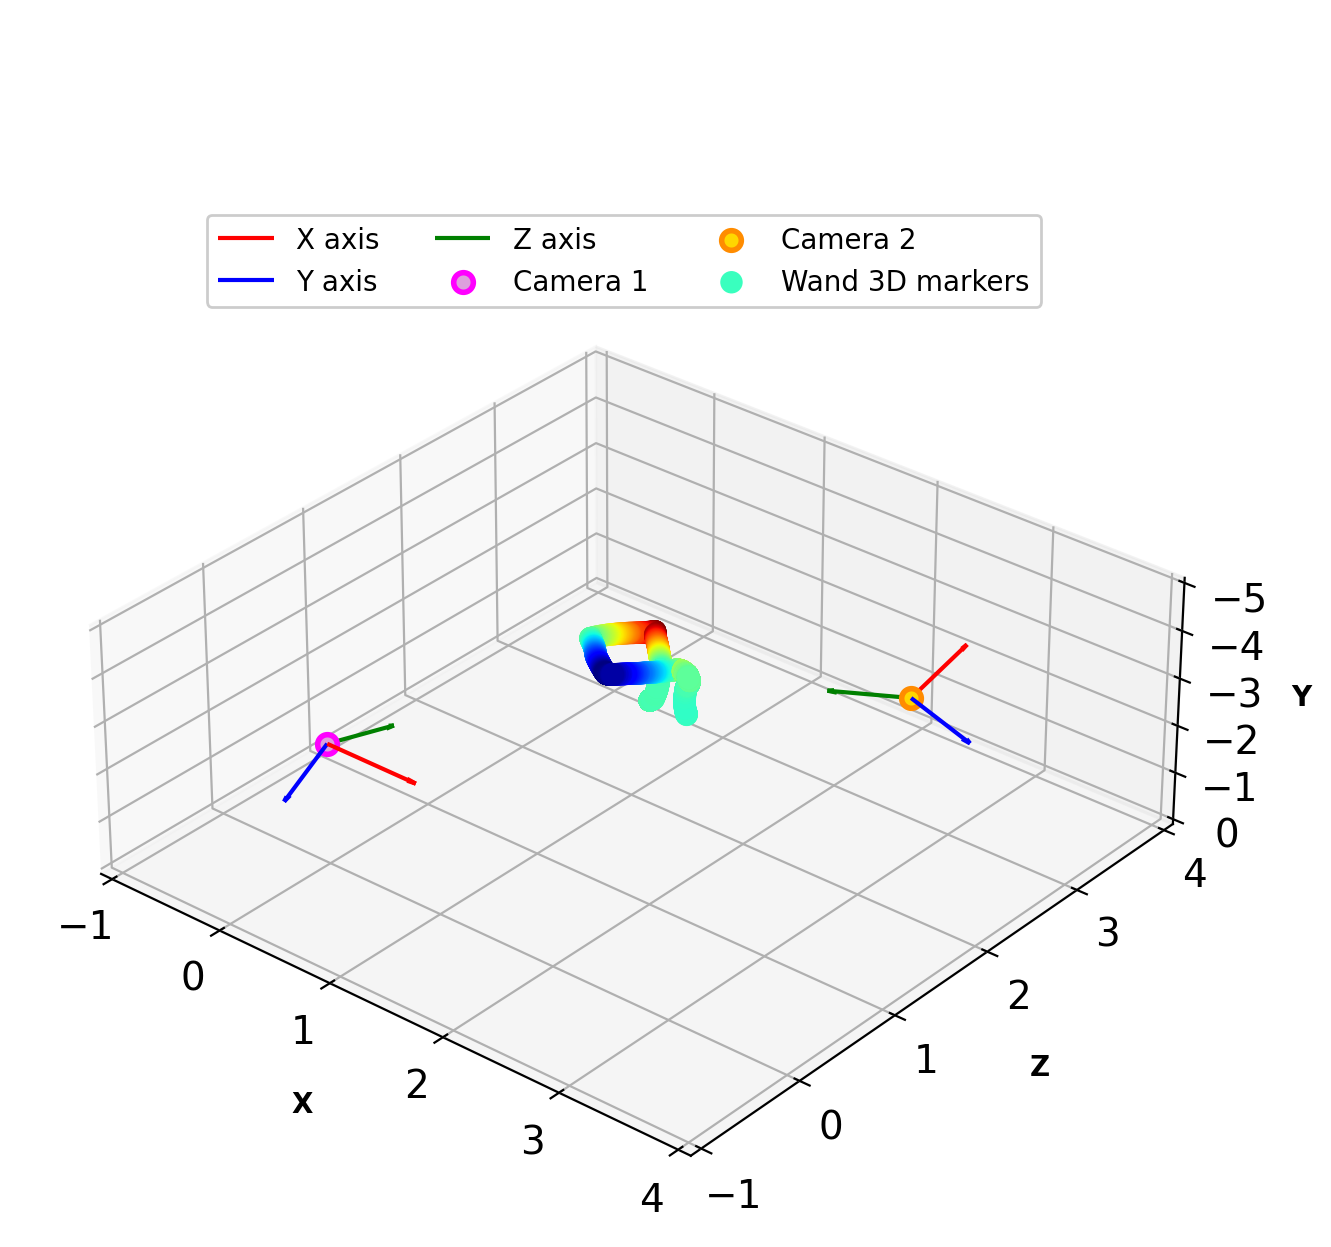

In [516]:
#projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
#points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
#points3d = (points4d[:3, :]/points4d[3, :]).T
#if points3d[0, 2] < 0: points3d = -points3d
idx = np.array(range(3,points3d.shape[0],4)).astype(int)
points3dNew = points3d[idx]*lamb/100
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
# plot first camera
scale = 0.8
cam1Pts = np.array([[0,d/b,0],
                    [scale, 0, 0],
                    [0, scale, 0],
                    [0, 0, scale]])
cam1PtsNew = np.matmul(R_plane,cam1Pts.T).T
[cam1Root,x,y,z]=cam1PtsNew
zDisplacement = cam1PtsNew[0,2]
cam1Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r", label = 'X axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b", label = 'Y axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g", label = 'Z axis')
ax.scatter(cam1Root[0],cam1Root[2],cam1Root[1], s=50, edgecolor="fuchsia", facecolor="plum", linewidth=2, label = 'Camera 1')
# plot second camera
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
x,y,z = np.matmul(R.T, x),np.matmul(R.T, y),np.matmul(R.T, z)
t_aux = np.matmul(-t, R)[0]*lamb/100+[0,d/b,0]
cam2Pts = np.array([t_aux.T,x,y,z])
cam2PtsNew = np.matmul(R_plane,cam2Pts.T).T
[cam2Root,x,y,z]=cam2PtsNew
cam2Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(cam2Root[0],cam2Root[2],cam2Root[1], s=50, edgecolor="darkorange", facecolor="gold", linewidth=2,  label = 'Camera 2')
# new plane
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
ax.scatter(points3dNew[:, 0], points3dNew[:, 2]-zDisplacement, points3dNew[:, 1], c=points3dNew[:, 2], cmap=cmhot,s = 50,label='Wand 3D markers')
# axis setup
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
plt.draw()
plt.show()

In [517]:
#points3d_A = np.savetxt('points3d_A.csv',points3d[np.array(range(0,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_B = np.savetxt('points3d_B.csv',points3d[np.array(range(1,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_C = np.savetxt('points3d_C.csv',points3d[np.array(range(2,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_D = np.savetxt('points3d_D.csv',points3d[np.array(range(3,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')

In [518]:
for k in range(0,4):
    idx = np.array(range(k,points3d.shape[0],4)).astype(int)
    points3dNew = points3d[idx]*lamb/100
    points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
    print('marker',k,'max',-min(points3dNew[:,1]),'m,','min',-max(points3dNew[:,1]),'m')
    
    #np.savetxt('points3d'+str(k)+'.csv',points3dNew,delimiter=',')

marker 0 max 0.8793837733352312 m, min 0.03548814851146753 m
marker 1 max 0.8773131684627888 m, min 0.032580008324653686 m
marker 2 max 0.8752288989353989 m, min 0.03203177230235088 m
marker 3 max 0.8910159548308356 m, min 0.0490178830978798 m


In [519]:
[A,B,C,D] = points3d[-4:]*lamb
print('0-1 >> ??.?cm >> '+str(np.linalg.norm(A-B)))
print('0-2 >> 11.5cm >> '+str(np.linalg.norm(A-C)))
print('0-3 >> 17.0cm >> '+str(np.linalg.norm(A-D)))
print('1-2 >> 10.5cm >> '+str(np.linalg.norm(B-C)))
print('1-3 >> 21.5cm >> '+str(np.linalg.norm(B-D)))
print('2-3 >> 11.0cm >> '+str(np.linalg.norm(D-C)))

0-1 >> ??.?cm >> 13.387984025165556
0-2 >> 11.5cm >> 11.319955146713461
0-3 >> 17.0cm >> 16.724742290372475
1-2 >> 10.5cm >> 10.495242517083847
1-3 >> 21.5cm >> 21.250840386547505
2-3 >> 11.0cm >> 10.849683985174448


In [520]:
'''np.savetxt('R.csv',R,delimiter=',')
np.savetxt('t.csv',t,delimiter=',')
np.savetxt('lamb.csv',np.array([lamb]),delimiter=',')
np.savetxt('F.csv',F,delimiter=',')
np.savetxt('R_plane.csv',R_plane,delimiter=',')
np.savetxt('t_plane.csv',np.array([d/b]),delimiter=',')'''


"np.savetxt('R.csv',R,delimiter=',')\nnp.savetxt('t.csv',t,delimiter=',')\nnp.savetxt('lamb.csv',np.array([lamb]),delimiter=',')\nnp.savetxt('F.csv',F,delimiter=',')\nnp.savetxt('R_plane.csv',R_plane,delimiter=',')\nnp.savetxt('t_plane.csv',np.array([d/b]),delimiter=',')"

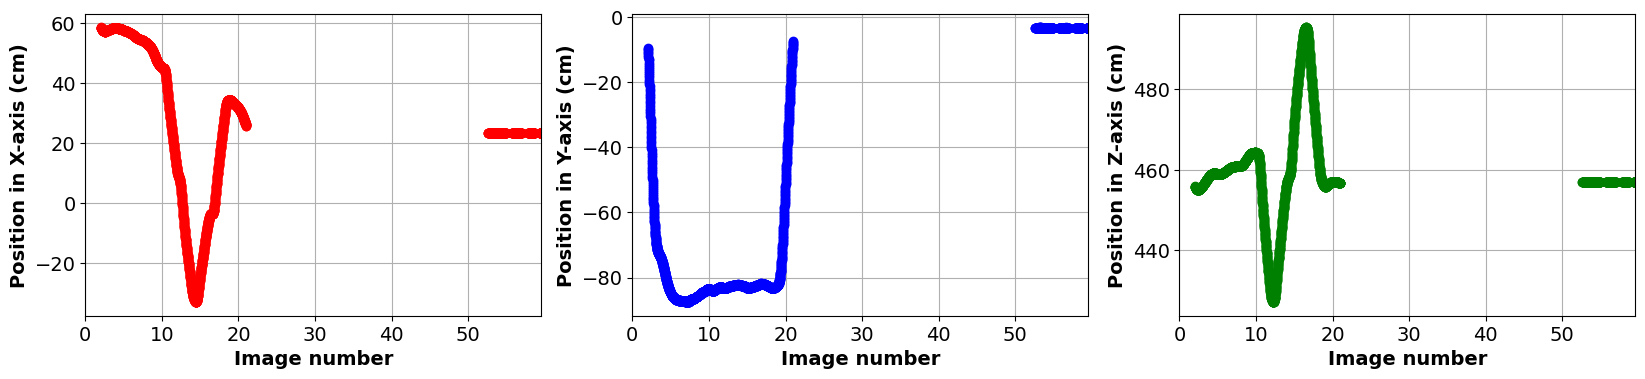

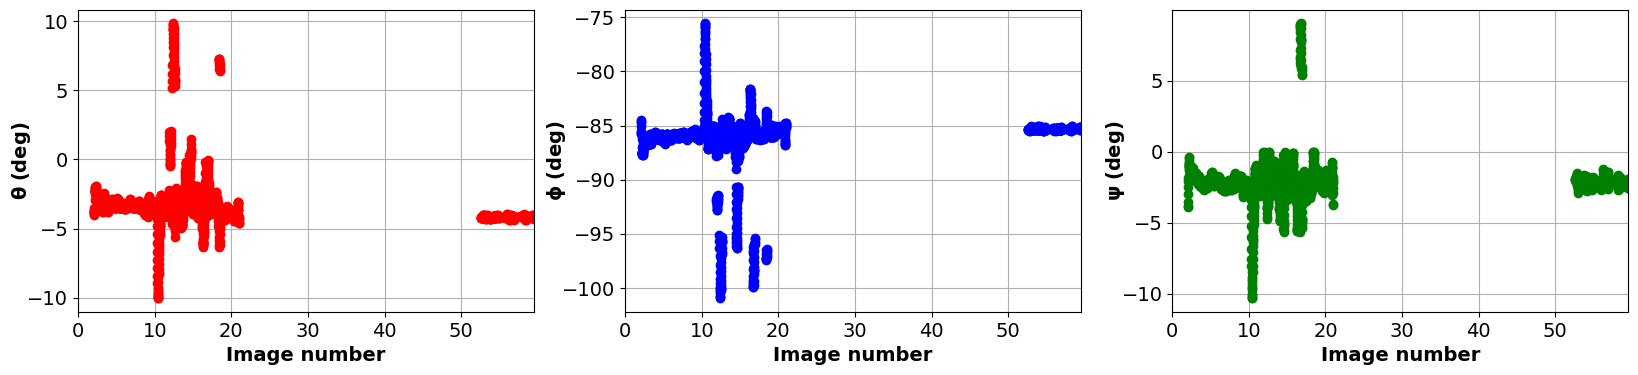

In [521]:
def getAngle(a,b):
    cosPhi = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    phi = np.arccos(cosPhi)
    return np.arctan2(np.sin(phi),cosPhi)


points3dNew = points3d*lamb/100
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
allCombinationsOf2 = np.array(list(combinations(list(range(0,4)),2)))
points3d_rightTriangle = []
points3d_centreOfMass = []
for k in range(0,int(points3dNew.shape[0]/4)):
    pts,myIdx = points3dNew[k*4:k*4+4],[]
    for idx in allCombinationsOf2:
        if np.linalg.norm(np.diff(pts[idx],axis=0)) > 0.15:
            myIdx.append(idx)
    myIdx = np.unique(myIdx)
    centreOfMass = [i for i in range(0,4) if i not in myIdx]
    if not len(points3d_rightTriangle): 
        points3d_centreOfMass = pts[centreOfMass]
        points3d_rightTriangle = pts[myIdx]
    else: 
        points3d_centreOfMass = np.vstack((points3d_centreOfMass,pts[centreOfMass]))
        points3d_rightTriangle = np.vstack((points3d_rightTriangle,pts[myIdx]))
# position of centre of mass
fig, axs = plt.subplots(1,3,figsize=(20,4),dpi=100)
colour = ['r','b','g']
label = ['Position in X-axis (cm)','Position in Y-axis (cm)','Position in Z-axis (cm)']
for k in range(0,3):
    axs[k].plot(dfInterp[:,-1],points3d_centreOfMass[:,k]*100,'o',c=colour[k],linewidth=3)
    axs[k].set_xlim((0,dfInterp[-1,-1]))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],fontweight='bold',size=14)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
# get orientation
myOrientation = []
for k in range(0,int(points3d_rightTriangle.shape[0]/3)):
    pts = points3d_rightTriangle[k*3:k*3+3]
    plane = findPlane(pts[0],pts[1],pts[2])
    if np.any(plane[0:3]<0): plane = findPlane(pts[0],pts[2],pts[1])
    theta = np.rad2deg(getAngle(plane[0:3],[1,0,0]))-90
    phi = np.rad2deg(getAngle(plane[0:3],[0,1,0]))-90
    if phi > 0: phi-=180
    psi = np.rad2deg(getAngle(plane[0:3],[0,0,1]))-90
    if not len(myOrientation): myOrientation = [theta,phi,psi]
    else: myOrientation = np.vstack((myOrientation,[theta,phi,psi]))
fig, axs = plt.subplots(1,3,figsize=(20,4),dpi=100)
colour = ['r','b','g']
label = [r'$\mathbf{\theta\;(deg)}$',r'$\mathbf{\phi\;(deg)}$',r'$\mathbf{\psi\;(deg)}$']
for k in range(0,3):
    axs[k].plot(dfInterp[:,-1],myOrientation[:,k],'o',c=colour[k],linewidth=3)
    axs[k].set_xlim((0,dfInterp[-1,-1]))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],size=14,labelpad=-4)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
